# Algorytmy macierzowe - zadanie nr 4 - Eliminacja Gaussa i Cholesky’ego dla macierzy rzadkich

2. Wierszowa rzadka eliminacja Cholesky'ego w formacie CSR.

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

In [1]:
import numpy as np
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import os
from time import time
from read_matrix import read_matrix

## Generowanie macierzy

In [2]:
matrices  = {}
for file in os.listdir('matrices'):
    matrices[file[:2]]= read_matrix('matrices/' + file)

## Eliminacja Cholesky'ego dla macierzy gęstych

Poniższa funkcja służy do znalezienia faktoryzacji Cholesky'ego dla macierzy gęstych.

In [3]:
def cholesky_LLT(matrix):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n):
        if abs(A[k, k]) < 1e-8:
            raise ValueError('singular matrix')
            
        A[k, k] **= 0.5
        dkk = A[k, k]
        for j in range(k+1, n):
            A[k, j] = A[k, j] / dkk
        
        vk = [A[k, j] for j in range(k+1, n)]
        
        for j in range(k+1, n):
            for m in range(j, n):
                A[j, m] -= A[k, m]*vk[j-k-1]        
        
    return np.triu(A).T

## Format CSR

Poniższa funkcja służy do konwersji zadanej macierzy do formatu Compressed Sparse Row. 

In [4]:
def convert_to_csr(matrix):
    m, n = matrix.shape
    ICL = []
    VAL = []
    ROWPTR = []
    counter = 0
    
    for i in range(n): # rows
        ROWPTR.append(counter)
        for j in range(m): # columns
            val_ij = matrix[i, j]
            if abs(val_ij) < 1e-8:
                continue
            ICL.append(j)
            VAL.append(val_ij)
            counter += 1
            
    ROWPTR.append(counter)
    
    return ICL, VAL, ROWPTR

## Eliminacja Cholesky'ego dla macierzy rzadkich

Poniższa funkcja pomocnicza pozwala zaoszczędzić czas wyszukania konkretnej wartości w wierszu. Zamiast liniowego przechodzenia po wierszu, wykorzystuje ona wyszukiwania połówkowe, aby osiągnąć złożoność logarytmiczną.

In [5]:
def get_col_in_row(row, col):
    '''binary search for an index of value col in array row
        if col not in row returns index of the first bigger value than col
        if every value in row is smaller than col then returns None'''
    start = 0
    end = len(row)-1

    while start < end:
        middle = (start+end)//2
        if row[middle] < col:
            start = middle+1
        else:
            end = middle

    if row[start] == col:
        return start
    else:
        if start + 1 < len(row):
            return start + 1
        return None

Funkcja sparse_cholesky implementuje procedurę eliminacji Cholesky'ego dla macierzy przekazanych w formacie CSR.

In [6]:
def sparse_cholesky(matrix):
    '''
        returns L.T matrix in CSR format
        that (L.T.)T @ L.T == matrix
    '''
    
    ICL, VAL, ROWPTR = matrix
    n = len(ROWPTR) - 1
   
    for k in range(n):
        row_start = ROWPTR[k]
        row_end = ROWPTR[k+1]
        
        if ICL[row_start] != k or VAL[row_start] < 0:
            raise Exception('nonpositive value on diagonal')
    
        VAL[row_start] **= 0.5
        dkk = VAL[row_start]
        
        # last row -> nothing to eliminate
        if k == n-1: 
            break

        for j in range(row_start+ 1, row_end):
            VAL[j] /= dkk

        # new arrays for ICL, VAL, ROWPTR 
        # starting with part of the matrix that won't be eliminated
        # later we're adding all other values after each elimination step
        new_icl = ICL[:row_end]
        new_val = VAL[:row_end]
        new_rowptr = ROWPTR[:k+2]
        
        vk_index = row_start + 1

        for j in range(k+1, n):
            # top_row = kth_row (not always 0th row!)
            # j_row = jth_row
            # we aim to calculate:  j_row = j_row - top_row*vk
            j_row_start = ROWPTR[j]
            j_row_end = ROWPTR[j+1]

            # we find indices in top_row ICL and j_row ICL on which value j is, 
            # so we can start eliminating from there
            j_index_j_row = get_col_in_row(ICL[j_row_start:j_row_end], j)
            j_index_top_row = get_col_in_row(ICL[row_start:row_end], j)
            
            # if vk is 0, we just copy j_row from jth index and continue to the next row
            if vk_index >= row_end or ICL[vk_index] != j:
                if j_index_j_row is not None:
                    new_icl += ICL[j_row_start+j_index_j_row:j_row_end]
                    new_val += VAL[j_row_start+j_index_j_row:j_row_end]
                    
                new_rowptr.append(len(new_icl))
                continue
                
            vk = VAL[vk_index]
            
            # if both top row and jth row are empty after jth index, we move onto the next row
            if j_index_j_row is None and j_index_top_row is None:
                new_rowptr.append(len(new_icl))
                continue
    
            # if jth row is empty after jth index we copy -vk*top_row
            if j_index_j_row is None:
                new_icl += ICL[row_start + j_index_top_row:row_end]
                new_val += [-vk*x for x in VAL[row_start +
                                               j_index_top_row:row_end]]
                new_rowptr.append(len(new_icl))
                continue
            else:
                 j_row_index = j_row_start + j_index_j_row
            
            # if top row is empty after jth index we just copy jth row as it is
            if j_index_top_row is None:
                new_icl += ICL[j_row_index:j_row_end]
                new_val += VAL[j_row_index:j_row_end]
                new_rowptr.append(len(new_icl))
                continue
            else:
                top_row_index = row_start + j_index_top_row
                

            # we iterate through top_row and j_row at the same time
            # doing the elimination
            # new non-zero values may occur
            while j_row_index < j_row_end and top_row_index < row_end:
                top_col = ICL[top_row_index]
                j_col = ICL[j_row_index]

                # nonzero value in kth row, zero in jth
                # new nonzero value
                if top_col < j_col:
                    val = -vk*VAL[top_row_index]
                    if abs(val) > 1e-8:
                        new_icl.append(top_col)
                        new_val.append(val)
                    top_row_index += 1
                
                # both values nonzero
                elif top_col == j_col:
                    val = VAL[j_row_index]-vk*VAL[top_row_index]
                    if abs(val) > 1e-8:
                        new_icl.append(top_col)
                        new_val.append(val)

                    top_row_index += 1
                    j_row_index += 1
                
                # nonzero in jth row, but zero in k
                elif top_col > j_col:
                    new_icl.append(j_col)
                    new_val.append(VAL[j_row_index])
                    j_row_index += 1
            
            # there might still be nonzero values in jth row
            # and just zeros in kth
            while j_row_index < j_row_end:
                new_icl.append(ICL[j_row_index])
                new_val.append(VAL[j_row_index])
                j_row_index += 1

            # there might still be nonzero values in kth row
            # and just zeros in jth
            while top_row_index < row_end:
                val = -vk*VAL[top_row_index]
                if abs(val) > 1e-8:
                    new_icl.append(ICL[top_row_index])
                    new_val.append(val)
                top_row_index += 1

            new_rowptr.append(len(new_icl))
            
            if vk_index < row_end and ICL[vk_index] == j:
                vk_index += 1

        ICL = new_icl
        ROWPTR = new_rowptr
        VAL = new_val

    return ICL, VAL, ROWPTR

## Test

In [7]:
def get_matrix_from_CSR(A):
    ICL, VAL, ROWPTR = A
    VAL = VAL.copy()
    
    n = len(ROWPTR) - 1
    matrix = np.zeros((n, n))

    for row in range(n):
        for j in range(ROWPTR[row], ROWPTR[row+1]):
            matrix[row, ICL[j]] = VAL[j]
            
    return matrix

In [8]:
def print_CSR_matrix(A):
    print(get_matrix_from_CSR(A))

In [9]:
test_matrix = np.array([
    [25, 0, 5, 0, 10],
    [0, 36, 0, 0, 0],
    [0, 0, 9, 0, 0],
    [0, 0, 0, 100, 0],
    [0, 0, 0, 0, 14]
], dtype=float)


lt = cholesky_LLT(test_matrix).T
sparse_lt = sparse_cholesky(convert_to_csr(test_matrix))
dense_result = get_matrix_from_CSR(sparse_lt)

print('L.T obliczone funkcją dla macierzy gęstych:')
print(lt)

print('\nL.T obliczone funkcją dla macierzy rzadkich: ')
print(dense_result)

print('\nCorrect!' if np.allclose(dense_result, lt) else '\nWrong')

L.T obliczone funkcją dla macierzy gęstych:
[[ 5.          0.          1.          0.          2.        ]
 [ 0.          6.          0.          0.          0.        ]
 [ 0.          0.          2.82842712  0.         -0.70710678]
 [ 0.          0.          0.         10.          0.        ]
 [ 0.          0.          0.          0.          3.082207  ]]

L.T obliczone funkcją dla macierzy rzadkich: 
[[ 5.          0.          1.          0.          2.        ]
 [ 0.          6.          0.          0.          0.        ]
 [ 0.          0.          2.82842712  0.         -0.70710678]
 [ 0.          0.          0.         10.          0.        ]
 [ 0.          0.          0.          0.          3.082207  ]]

Correct!


In [10]:
for idx, test_matrix in enumerate(matrices.values()):
    lt = cholesky_LLT(test_matrix).T
    sparse_lt = sparse_cholesky(convert_to_csr(test_matrix))
    dense_result = get_matrix_from_CSR(sparse_lt)
    print('Correct!' if np.allclose(dense_result, lt) else 'Wrong')

Correct!
Correct!


Porównując otrzymane macierze z procedur faktoryzacji w wersji dla macierzy gęstych i rzadkich mogliśmy upewnić się o poprawności implementacji.

## Porównanie czasów

In [11]:
def compare_times(matrix):
    start = time()
    cholesky_LLT(matrix)
    dense_time = time() - start
    
    start = time()
    sparse_cholesky(convert_to_csr(matrix))
    sparse_time = time() - start
    
    df = pd.DataFrame({
        'dense': [dense_time],
        'sparse': [sparse_time]
    }, index=['time [s]'])
    
    df.plot(kind='bar', cmap='viridis')
    return df

* 3a

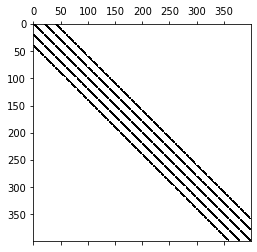

In [12]:
plt.spy(matrices['3a'])
plt.show()

,dense,sparse
time [s],3.888042,0.144082


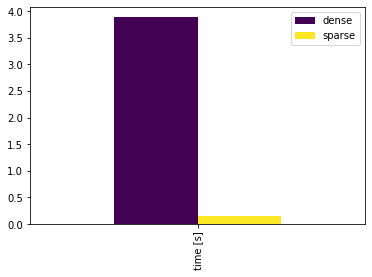

In [13]:
compare_times(matrices['3a'])

* 4a

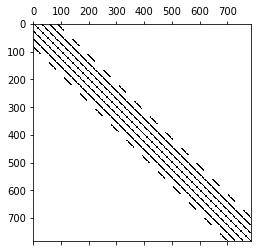

In [14]:
plt.spy(matrices['4a'])
plt.show()

,dense,sparse
time [s],29.723092,0.60271


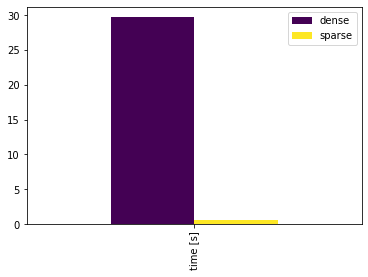

In [15]:
compare_times(matrices['4a'])

* macierz przekątniowa

,dense,sparse
time [s],29.781755,0.335715


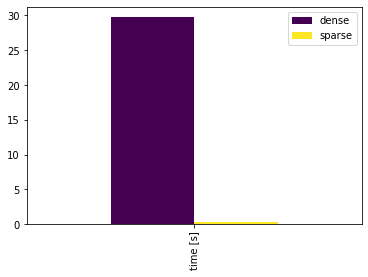

In [18]:
diagonal_matrix = np.eye(784, 784)
compare_times(diagonal_matrix)

Dla testowanych macierzy rzadkich udało nam się zaobserwować znaczną poprawę czasu działania procedury.

## Wnioski

* Wykorzystując specjalne formaty dla macierzy rzadkich, jesteśmy w stanie zmniejszyć koszt pamięciowy i czasowy wybranych algorytmów.
* Procedury dla macierzy rzadkich są bardziej skomplikowane od klasycznych i dają lepsze wyniki dla macierzy o małym stosunku liczby niezerowych wartości do rozmiaru macierzy.
* W przypadku formatu CSR ważna jest dobra kolejność odwołań do pamięci, gdyż iteracja najpierw po wierszach, a następnie po kolumnach w danym wierszu jest dużo łatwiejsza i szybsza od tej w odwrotnej kolejności.

M. Hawryluk, N. Wolniak. 2021